In [11]:
import os
from thermof.read import read_log, read_thermo
import numpy as np
from wham import *
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
thermo_headers = 'Step Temp Press TotEng E_pair E_mol Fmax Fnorm c_C1[1] c_C1[2] c_C1[3]'
thermo_keys = ['step', 'temp', 'press', 'etotal', 'epair', 'emol', 'fmax', 'fnorm', 'x', 'y', 'z']

In [13]:
scandir = 'data/scan2'
scanlist = [os.path.join(scandir, i) for i in os.listdir(scandir)]
whamdir = os.path.abspath('wham')

### Write 1D WHAM time series files

In [14]:
start_pos = {}
for simdir in scanlist:
    logfile = os.path.join(simdir, 'log.HtBDC_Cu110')
    try:
        _, xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        thermo_data = read_log(logfile, headers=thermo_headers)
        thermo = read_thermo(thermo_data, headers=thermo_keys)[0]
        # Write time series files
        for drx in ['x', 'y']:
            timeseriesfile = os.path.join(whamdir, 'data', '%i-%i-%s.dat' % (xi ,yi, drx))
            time = timesteps_to_time(thermo['step'], dt=1, conversion=1e-3)  # femtosecond -> picosecond
            write_timeseries_file(timeseriesfile, time, thermo[drx])
            # Record starting position (min energy pos)
            start_pos['%i-%i-%s' % (xi ,yi, drx)] = thermo[drx][0]
    except Exception as e:
        print(e, logfile)

### Write 1D WHAM input files - x

In [ ]:
nx, ny = 19, 14
drx = 'x'

In [19]:
for ypos in range(ny):
    tsfiles, mins = [], []
    for xpos in range(nx):
        tsfiles.append(os.path.join(whamdir, 'data', '%i-%i-%s.dat' % (xpos ,ypos, drx)))
        mins.append(start_pos['%i-%i-%s' % (xpos ,ypos, drx)])
    datafile = os.path.join(whamdir, 'wham-1d', '%i-%s.in' % (ypos, drx))
    spring_k = [5.0] * len(tsfiles)
    write_data_file(datafile, tsfiles, mins, spring_k)

### Run 1D WHAM - x-direction

In [20]:
import subprocess

In [21]:
drx = 'x'
hist_min, hist_max = 21.582, 25.182
bin_size = 0.1
num_bins = np.ceil((hist_max - hist_min) / bin_size)
tolerance = 1e-5
temperature = 200
numpad = 0
wham_exec = '/home/kutay/Documents/Research/Software/wham/wham/wham'

In [22]:
ypos = 0
datafile = os.path.join(whamdir, 'wham-1d', '%i-%s.in' % (ypos, drx))
outfile = os.path.join(whamdir, 'wham-1d', 'out', '%i-%s.out' % (ypos, drx))

In [23]:
wham_args = [wham_exec, hist_min, hist_max, num_bins, tolerance, temperature, numpad, datafile, outfile]
data = run_wham(wham_args)

In [24]:
whamdata = []
for ypos in range(ny):
    datafile = os.path.join(whamdir, 'wham-1d', '%i-%s.in' % (ypos, drx))
    outfile = os.path.join(whamdir, 'wham-1d', 'out', '%i-%s.out' % (ypos, drx))
    wham_args = [wham_exec, hist_min, hist_max, num_bins, tolerance, temperature, numpad, datafile, outfile]
    data = run_wham(wham_args)
    whamdata.append(data)

In [38]:
def subplot(plot_fun, plot_data, plot_args={}, nrow=1, width=3, height=3, dpi=200, wspace=0.25, hspace=0.5, save=None, title=None, suptitle=None):
    n_plots = len(plot_data)
    ncol = np.ceil(n_plots / nrow)
    figsize = (ncol * width, nrow * height)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    for idx, data in enumerate(plot_data, start=1):
        plot_args['ax'] = fig.add_subplot(nrow, ncol, idx)
        plot_fun(data, **plot_args)
        if title is not None:
            plt.title(title[idx - 1])
    if suptitle is not None:
        plt.suptitle(suptitle, fontsize=14)
    if save is not None:
        plt.savefig(save, dpi=dpi, transparent=True, bbox_inches='tight')
        
def scatter_plot(data, ax):
    ax.plot(data['coor'], data['free'], '-o')
    plt.ylim(0, 0.16)

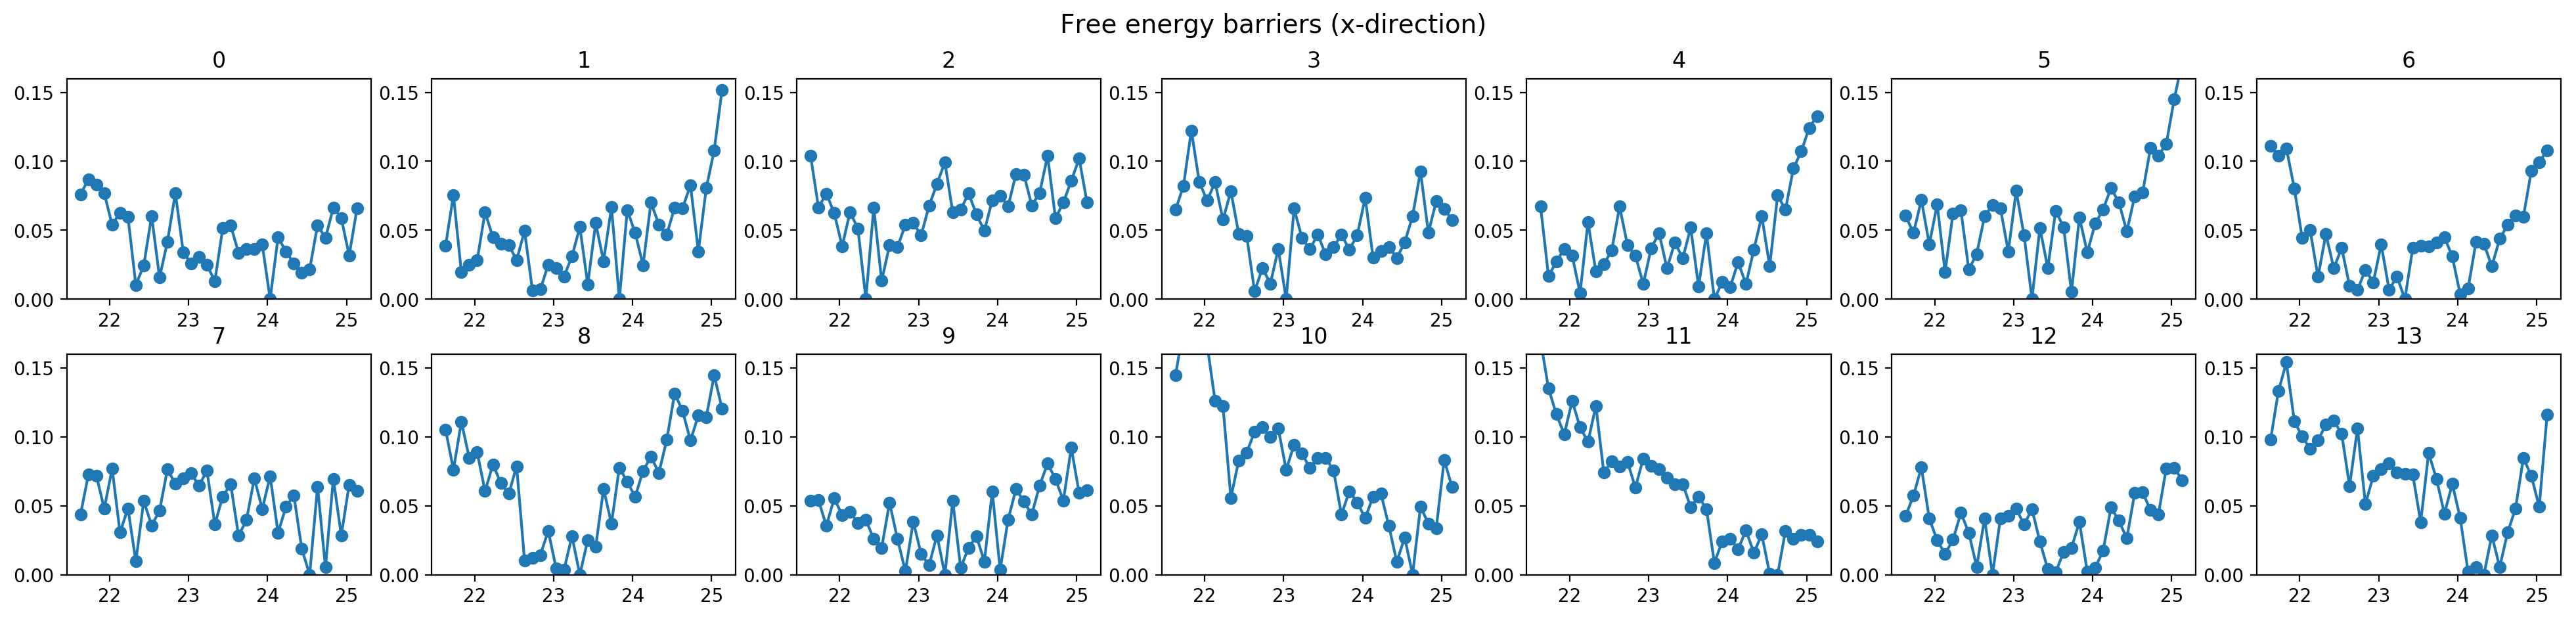

In [39]:
subplot(scatter_plot, whamdata, wspace=0.2, height=2.5, hspace=0.25, nrow=2, width=3.5, suptitle='Free energy barriers (x-direction)', title=np.arange(14))

In [108]:
matrixdata = np.zeros((len(whamdata[0]['coor']), 14))
for yi, data in enumerate(whamdata):
    for xi, free in enumerate(data['free']):
        matrixdata[xi][yi] = free

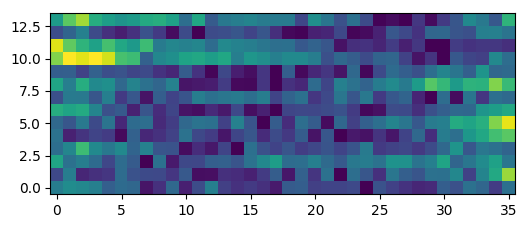

In [113]:
plt.imshow(matrixdata.T, origin='lower')
# plt.colorbar()

### Run WHAM 1D - y-direction

In [20]:
nx, ny = 19, 14
drx = 'y'

In [21]:
for xpos in range(nx):
    tsfiles, mins = [], []
    for ypos in range(ny):
        tsfiles.append(os.path.join(whamdir, 'data', '%i-%i-%s.dat' % (xpos ,ypos, drx)))
        mins.append(start_pos['%i-%i-%s' % (xpos ,ypos, drx)])
    datafile = os.path.join(whamdir, 'wham-1d', '%i-%s.in' % (xpos, drx))
    spring_k = [5.0] * len(tsfiles)
    write_data_file(datafile, tsfiles, mins, spring_k)

In [54]:
hist_min, hist_max = 22.8, 25.5
bin_size = 0.1
num_bins = np.ceil((hist_max - hist_min) / bin_size)
tolerance = 1e-5
temperature = 200
numpad = 0
wham_exec = '/home/kutay/Documents/Research/Software/wham/wham/wham'

In [55]:
xpos = 0
datafile = os.path.join(whamdir, 'wham-1d', '%i-%s.in' % (xpos, drx))
outfile = os.path.join(whamdir, 'wham-1d', 'out', '%i-%s.out' % (xpos, drx))

In [56]:
wham_args = [wham_exec, hist_min, hist_max, num_bins, tolerance, temperature, numpad, datafile, outfile]
data = run_wham(wham_args, verbose=False)

In [57]:
xlim = (22.5, 26)

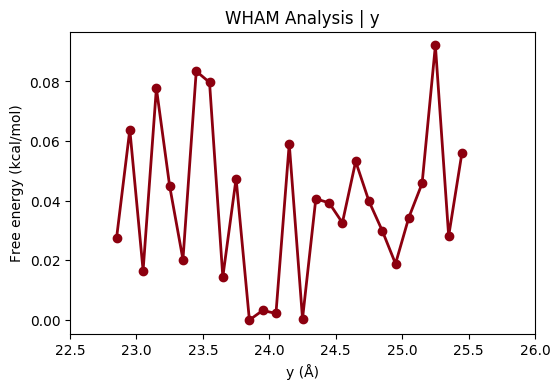

In [58]:
plt.plot(data['coor'], data['free'], '-o', c='xkcd:crimson', lw=2, markersize=6)
plt.xlim(xlim)
plt.xlabel('%s (Å)' % drx)
plt.ylabel('Free energy (kcal/mol)')
plt.title('WHAM Analysis | %s' % drx)

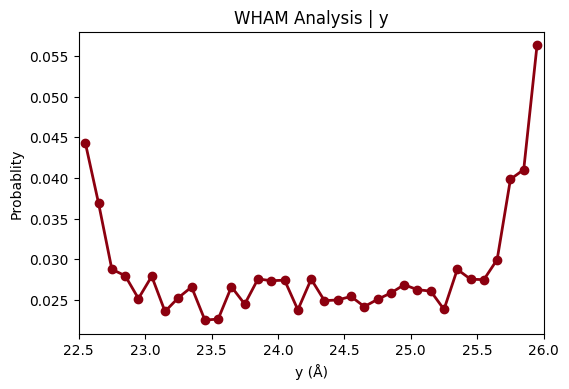

In [53]:
plt.plot(data['coor'], data['prob'], '-o', c='xkcd:crimson', lw=2, markersize=6)
plt.xlim(xlim)
plt.xlabel('%s (Å)' % drx)
plt.ylabel('Probablity')
plt.title('WHAM Analysis | %s' % drx)